# EuroSciPy 2011: Advanced SciPy

**Prerequisites:** Proficiency with NumPy and matplotlib

**Software requirements:** [IPython](http://ipython.org),
[NumPy](http://numpy.org), [SciPy](http://scipy.org), [Cython](http://cython.org) (optional), [matplotlib](http://matplotlib.sf.net)

<br/>
[Python(x,y)](http://www.pythonxy.com) and [EPD](http://www.enthought.com/products/epd.php) provide
one-click installers.

<br/>
Make sure that you can execute the following commands before the tutorial:

    import numpy
    print numpy.__version__

    import scipy
    print scipy.__version__

    import matplotlib.pyplot as plt
    plt.plot([1, 2, 3])
    plt.show()

**Content:** We give a brief overview of the scipy package in
terms of infrastructure, packaging, its relation to scikits,
build requirements, etc. After examining the structure of the
numpy array, we interactively explore certain scipy components,
such as spatial, sparse and ndimage in more detail. We conclude
with a brief discussion of the other tools in the SciPy ecosystem
and a Q&A.

<br/>
*Note:* Since there is an advanced session on Image Processing already, we'll
skip ``ndimage`` and rather look at optimize.

<style type="text/css">
    .exercise {
        border: solid 3px #AAE;
        background: #EEF;
        padding: 50px 10px 50px 10px;
        display: inline-block;
        font-size: 110%;
    }
</style>


## How to install this notebook

- Grab the IPython repo from http://github.com/ipython/ipython
- Install the "htmlnotebook" branch
- Install Tornado web server ("easy_install tornado")
- If you're using Firefox, go to about:config and enable all websocket options.
- Start the notebook with ``ipython notebook --pylab=inline`` and connect to http://localhost:8888

## Spatial

### Visual Hull

In [70]:
import numpy as np
print(np.__version__)

import scipy as sp
print(sp.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

1.10.0.dev0+9dba7a4
0.16.0.dev0+bcf5fcd


<img src="files/triceratops.jpg">

<span class="exercise">
Load the `triceratops.obj` file using pandas or numpy.  Note that the file contains two types of data:
vertices and faces.  Try to get both out of the file.
</span>

In [82]:
import pandas as pd

df = pd.read_csv('triceratops.obj', sep=' ', names=('ptype', 'x', 'y', 'z'))
df.head()

,ptype,x,y,z
0,v,0.576047,-0.020750,-0.085114
1,v,0.582657,0.018125,-0.095803
2,v,0.611766,0.014097,-0.083653
3,v,0.622981,-0.005351,-0.075573
4,v,0.630173,-0.016425,-0.065138


In [84]:
points = df[df.ptype == 'v']
points = points[['x', 'y', 'z']].values
points

array([[ 0.576047  , -0.0207502 , -0.0851141 ],
       [ 0.582657  ,  0.0181254 , -0.0958034 ],
       [ 0.611766  ,  0.0140973 , -0.0836525 ],
       ..., 
       [ 0.978493  ,  0.0131669 , -0.00660234],
       [ 0.980024  ,  0.00981772, -0.00616342],
       [ 0.981451  ,  0.00729448, -0.00273231]])

In [86]:
face_idx = df[df.ptype == 'f']
face_idx = face_idx[['x', 'y', 'z']].values

faces = face_idx.astype(int) - 1  # zero-based indexing
faces.max(axis=0)

array([2830, 2830, 2831])

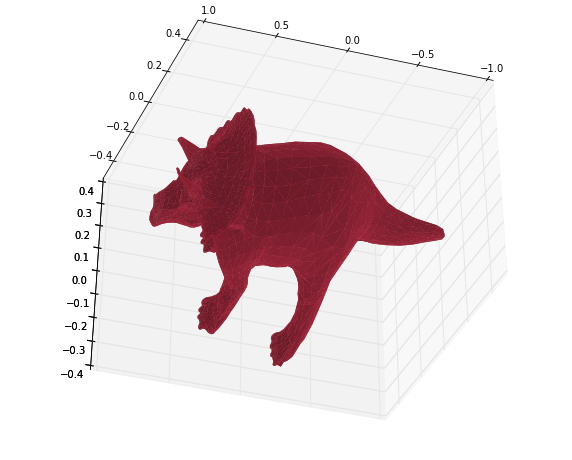

In [87]:
# Enable 3D plots in matplotlib
from mpl_toolkits.mplot3d import Axes3D
    
import numpy as np
import matplotlib.pyplot as plt

x, y, z = points.T

f = plt.figure()
ax = f.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=-40, azim=70)

ax.plot_trisurf(x, y, z, triangles=faces, shade=True, color=(0.8, 0.2, 0.3), linewidth=0)

## Or could have plotted data-points only:
# ax.plot3D(x, y, z, '.')

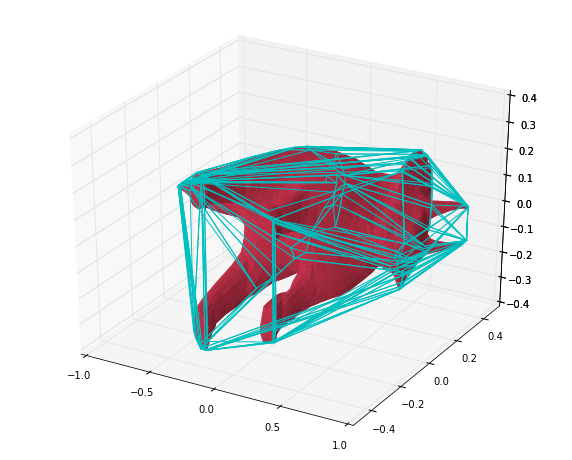

In [80]:
import scipy.spatial as ss

d = ss.Delaunay(points)
triangles = d.points[d.convex_hull]

f = plt.figure()
ax = f.add_subplot(1, 1, 1, projection='3d')

ax.plot_trisurf(x, y, z, triangles=faces, shade=True, color=(0.8, 0.2, 0.3), linewidth=0)

for t in triangles:
    xx, yy, zz = t.T
    ax.plot(xx, yy, zz, 'c')

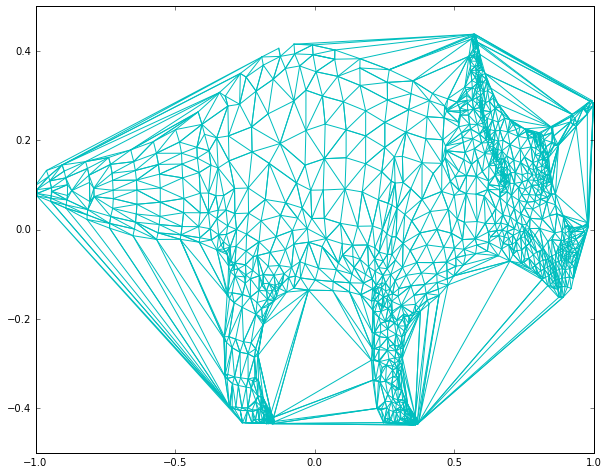

In [81]:
d = ss.Delaunay(points[..., :2])
simplexes = d.points[d.vertices]

f = plt.figure()

for s in simplexes:
    xx, yy = s.T
    plt.plot(xx, yy, 'c')

### KDTree

<span class="exercise">
**Exercise:** Construct a ``scipy.spatial.KDTree`` object from the point cloud,
and use the ``query_ball_point`` method to isolate the head of the dinosaur.
</span>

(0.40000000000000002, 1.0, -0.20000000000000001, 0.5)

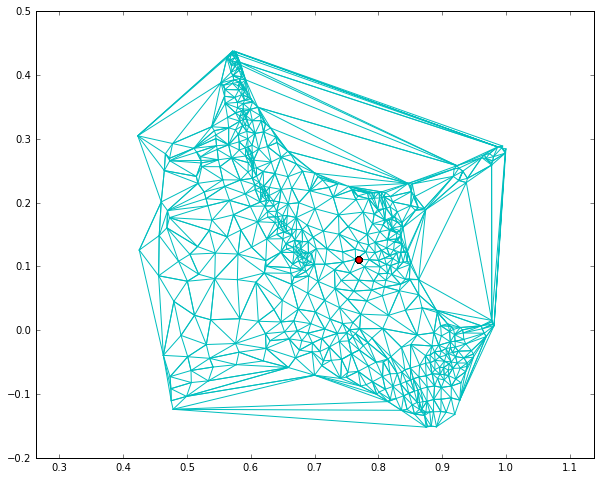

In [95]:
t = ss.KDTree(points)

query_idx = t.query_ball_point((0.77, 0.11, 0), r=0.4)
query_pts = points[query_idx]


# All below just for plotting purposes

d = ss.Delaunay(query_pts[..., :2])
simplexes = d.points[d.vertices]

for s in simplexes:
    xx, yy = s.T
    plt.plot(xx, yy, 'c')
    plt.plot([0.77], [0.11], 'ro')
    
plt.axis('equal')

## Sparse

<img src="files/sparse_graph.png"/>

### Types of sparse storage: CSR

In [97]:
import scipy.sparse as sparse

A = [[1, 0, 0, 2],
     [3, 4, 5, 0],
     [0, 3, 3, 0],
     [0, 0, 0, 1]]

S = sparse.csr_matrix(A)

print("Values:              ", S.data)
print("Positions:           ", S.indices)
print("Index into positions:", S.indptr)

Values:               [1 2 3 4 5 3 3 1]
Positions:            [0 3 0 1 2 1 2 3]
Index into positions: [0 2 5 7 8]


### Types of sparse storage: lil

In [98]:
A = [[1, 0, 0, 2],
     [3, 4, 5, 0],
     [0, 3, 3, 0],
     [0, 0, 0, 1]]
S = sparse.lil_matrix(A)

print("Values:      ", S.data)
print("Row-indices: ", S.rows)

Values:       [[1, 2] [3, 4, 5] [3, 3] [1]]
Row-indices:  [[0, 3] [0, 1, 2] [1, 2] [3]]


### Types of sparse storage: coo

In [100]:
A = [[1, 0, 0, 2],
     [3, 4, 5, 0],
     [0, 3, 3, 0],
     [0, 0, 0, 1]]
S = sparse.coo_matrix(A)

print("Values:      ", S.data)
print("Row-indices: ", S.row)
print("Col-indices: ", S.col)

Values:       [1 2 3 4 5 3 3 1]
Row-indices:  [0 0 1 1 1 2 2 3]
Col-indices:  [0 3 0 1 2 1 2 3]


All these containers trade off different construction, access and manipulation speeds.

### PageRank

Walk-through of: http://www.ams.org/samplings/feature-column/fcarc-pagerank

Let's start by constructing a tiny world-wide-web, where we have several pages linking to one another.

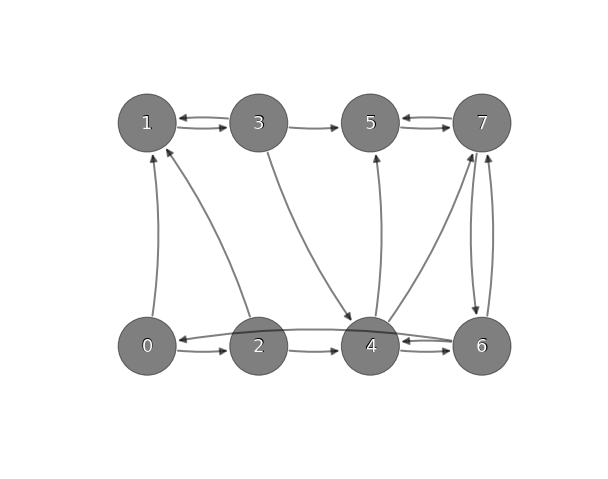

In [141]:
import networkx as nx
g = nx.DiGraph()
g.add_nodes_from(range(0, 7))
g.add_edges_from([(0,1), (0,2),
                  (1,3),
                  (2,1), (2,4),
                  (3,1), (3,5), (3,4),
                  (4,5), (4,6), (4,7),
                  (5,7),
                  (6,0), (6,4), (6,7),
                  (7,5), (7,6)])

n = np.arange(7)
rect_pos = {}
for col in range(4):
    for row in range(2):
        rect_pos[col * 2 + row] = (col / 2., row)
        
import nxdraw
nxdraw.draw_network(g, rect_pos)

## Or use built-in command:
# nx.draw_spring(g, with_labels=True)

Each node donates its popularity to other nodes.
<br/>
For example, node 1 has two links--to nodes 2 and 3. Each of those
nodes therefore gets $\frac{1}{2}$ of its popularity.
<br/>
This definition doesn't help us to find each page's popularity though, because
to find it we first need to know the popularity of its neighbours.
<br/>
To proceed, let's first write this problem in linear form:<br/><br/>

$$\mathbf{p} = \mathrm{H} \mathbf{p}$$
<br/>
In other words, each node's popularity can be written as a weighted
combination of the popularities of all nodes.  For those of you with a background
in linear algebra, the above should look familiar, especially if we rewrite it as
follow:<br/><br/>

$$\lambda \mathbf{p} = \mathrm{H} \mathbf{p}$$
<br/>

with $\lambda = 1$ is an eigenvalue problem.  Therefore, if we can find
the eigenvector of $\mathrm{H}$ associated with eigenvalue 1, we've found
the PageRank vector, $\mathbf{p}$.

In [170]:
# Build adjacency matrix
A = nx.adjacency_matrix(g).T

print(type(A))
print()

A = A.toarray()

print(A)
print()

# Convert nr of links to percentage.  Node can't
# donate more than 100% of popularity, so columns
# must sum to one.
H = A / np.sum(A, axis=0)

np.set_printoptions(precision=2)
print(H)

<class 'scipy.sparse.csc.csc_matrix'>

[[0 0 0 0 0 0 1 0]
 [1 0 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 0]
 [0 0 0 1 1 0 0 1]
 [0 0 0 0 1 0 0 1]
 [0 0 0 0 1 1 1 0]]

[[ 0.    0.    0.    0.    0.    0.    0.33  0.  ]
 [ 0.5   0.    0.5   0.33  0.    0.    0.    0.  ]
 [ 0.5   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.5   0.33  0.    0.    0.33  0.  ]
 [ 0.    0.    0.    0.33  0.33  0.    0.    0.5 ]
 [ 0.    0.    0.    0.    0.33  0.    0.    0.5 ]
 [ 0.    0.    0.    0.    0.33  1.    0.33  0.  ]]


<span class="exercise">
    <br/><br/><br/>
    **Exercise:** Find the eigenvector associated with eigenvalue 1, and determine the page rank.
    <br/><br/><br/><br/>
</span>

In [171]:
e, v = np.linalg.eig(H)
e

array([  1.00e+00+0.j  ,   4.25e-01+0.29j,   4.25e-01-0.29j,
        -8.70e-01+0.j  ,  -2.12e-01+0.25j,  -2.12e-01-0.25j,
        -2.81e-16+0.j  ,  -5.57e-01+0.j  ])

In [176]:
v0 = np.abs(v[:, 0])
print('v corresponding to λ=1:', v0)

page_rank = (v0 / v0.max())

print('Page rank:', page_rank)

v corresponding to λ=1: [ 0.14  0.16  0.07  0.16  0.23  0.47  0.42  0.69]
Page rank: [ 0.2   0.23  0.1   0.23  0.33  0.69  0.61  1.  ]


Let's plot nodes according to their pagerank:

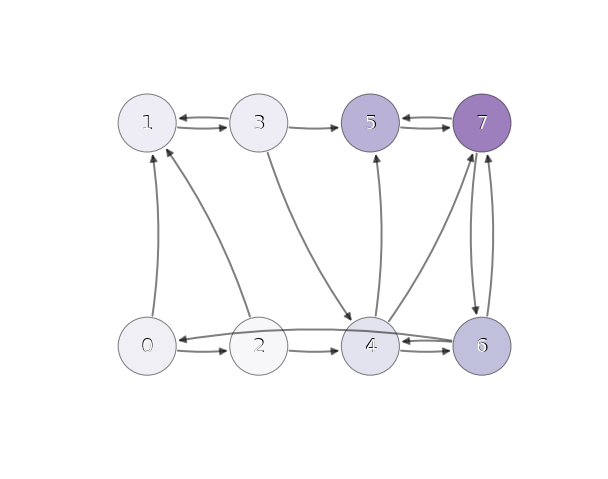

In [179]:
import nxdraw

nxdraw.draw_network(g,
            rect_pos,
            node_color=page_rank,
            cmap=plt.cm.Purples)

<span class="exercise">
**Exercise:** Investigate the cost of computing page-rank for a larger internet.
</span>
    
 1. Construct a random adjacency matrix for N nodes, with N varying between 100 and 800.
 2. Web pages are typically not very densely connected, so set at least 80%
    of the matrix to zero.
 3. Normalise the adjacency matrix, ensuring that columns sum to 1.
 4. Compute the eigenvector corresponding to an eigenvalue of one,
    using NumPy as illustrated above.
 5. Now, convert the array to a sparse matrix, and
    find a tool in ``scipy.sparse.linalg`` with which to do the same.
 6. How do the timings compare?

In [180]:
A = np.random.random((800, 800))
A[A > 0.2] = 0
H = A / np.sum(A, axis=0)

In [181]:
import numpy.linalg
%timeit np.linalg.eig(H)

1 loops, best of 3: 2.27 s per loop


In [182]:
import scipy.sparse as sparse
import scipy.sparse.linalg

Hs = sparse.csc_matrix(H)
%timeit sparse.linalg.eigs(Hs)

1 loops, best of 3: 1.65 s per loop


Clearly, Google has some magic machinery running in the background,
given the size of the matrix they have to work with!

### Convolution

## CPU vs Memory speed

In [198]:
%%file cpu_vs_mem.py

import numpy as np
import matplotlib.pyplot as plt
import timeit
import sys

N = 100*1000*1000
x = np.linspace(1, 10, N)

def raw():
    """Straight-forward NumPy evaluation of polynomial.

    """
    return (((.25 * x) + .75) * x - 1.5) * x - 2

def inplace(block_size=20000):
    """Blocked evaluation of polynomial.

    """
    y = np.empty(len(x))
    for k in range(len(x) // block_size + 1):
        b, e = k * block_size, (k+1) * block_size
        y[b:e] = x[b:e]
        y[b:e] *= .25
        y[b:e] += .75
        y[b:e] *= x[b:e]
        y[b:e] -= 1.5
        y[b:e] *= x[b:e]
        y[b:e] -= 2

    return y

def bench():
    """Illustrate CPU vs memory trade-off.

    Break up a computation in chunks and benchmark. Small blocks fit into
    cache easily, but the NumPy overhead and the outer Python for-loop takes
    long to execute.  With large blocks, the overhead for NumPy and the
    for-loop is negligible, but the blocks no longer fit into cache, resulting
    in delays.

    Returns
    -------
    block_sizes : list
        Size of the different data chunks.
    times : list
        Execution times.

    """
    times = []
    blocks = np.round(np.logspace(3, 7, num=50))
    for b in blocks:
        times.append(timeit.timeit('cpu_vs_mem.inplace(block_size=%d)' % b,
                                   'import cpu_vs_mem', number=1))
        print('Block size: %d  Execution time: %.2f' % (b, times[-1]))

    return blocks, times


blocks, times = bench()
plt.semilogx(blocks, times, 'o-')
plt.xlabel('Block size [b]')
plt.ylabel('Execution time [s]')
plt.title('CPU vs Memory Benchmark')

Overwriting cpu_vs_mem.py


Block size: 1000  Execution time: 0.51
Block size: 1207  Execution time: 0.34
Block size: 1456  Execution time: 0.25
Block size: 1758  Execution time: 0.22
Block size: 2121  Execution time: 0.20
Block size: 2560  Execution time: 0.19
Block size: 3089  Execution time: 0.17
Block size: 3728  Execution time: 0.17
Block size: 4498  Execution time: 0.16
Block size: 5429  Execution time: 0.15
Block size: 6551  Execution time: 0.14
Block size: 7906  Execution time: 0.14
Block size: 9541  Execution time: 0.13
Block size: 11514  Execution time: 0.14
Block size: 13895  Execution time: 0.13
Block size: 16768  Execution time: 0.13
Block size: 20236  Execution time: 0.13
Block size: 24421  Execution time: 0.14
Block size: 29471  Execution time: 0.12
Block size: 35565  Execution time: 0.13
Block size: 42919  Execution time: 0.12
Block size: 51795  Execution time: 0.12
Block size: 62506  Execution time: 0.12
Block size: 75431  Execution time: 0.12
Block size: 91030  Execution time: 0.13
Block size: 1

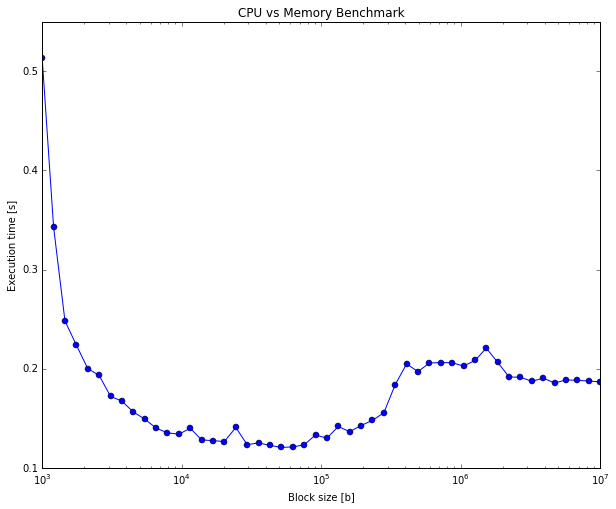

In [199]:
%run cpu_vs_mem.py

## Optimization using Cython

See external PDF slides.

# Q & A